<H1 style="text-align: center">ECMM426 - Computer Vision</H1>
<H1 style="text-align: center">Workshop 9</H1>
<H1 style="text-align: center">Object Detection on PASCAL VOC 2007</H1>
<H1 style="text-align: center">Multi-Class Setting</H1>


For this workshop, we will be finetuning a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) model on the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) dataset for Multiple Object Detection. It contains total 9,963 images containing 20 different objects: *aeroplane*, *bicycle*, *bird*, *boat*, *bottle*, *bus*, *car*, *cat*, *chair*, *cow*, *diningtable*, *dog*, *horse*, *motorbike*, *person*, *pottedplant*, *sheep*, *sofa*, *train*, *tvmonitor*. However, for this illustration we will use a subset of that dataset. First, we need to use the `pycocotools`, this library will be used for computing the evaluation metrics following the [Microsoft COCO](https://cocodataset.org/#home) metric for intersection over union. More detailed and complicated version of object detector can be found [here](https://github.com/facebookresearch/detectron2).

###Imports

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
import torchvision
import pycocotools
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

###Dataset
We will only download the `trainval` set and split it in our way. In reality, PASCAL VOC has a separate `test` split which is generally used for comparing detection methods. Please have a look on the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) dataset webpage for more details.

In [2]:
if not os.path.exists('VOCtrainval_06-Nov-2007.tar'):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
if not os.path.exists('VOCtest_06-Nov-2007.tar'):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!rm -r VOC2007/
!mkdir VOC2007/
!mkdir VOC2007/train/
!mkdir VOC2007/test/
!tar -xf VOCtrainval_06-Nov-2007.tar --directory VOC2007/train/
!tar -xf VOCtest_06-Nov-2007.tar --directory VOC2007/test/
!mv VOC2007/train/VOCdevkit/VOC2007/* VOC2007/train/
!rm -r VOC2007/train/VOCdevkit/
!mv VOC2007/test/VOCdevkit/VOC2007/* VOC2007/test/
!rm -r VOC2007/test/VOCdevkit/
class_str2num = {'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5,
                 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10,
                 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14,
                 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18,
                 'train': 19, 'tvmonitor': 20}
class_num2str = {v: k for k, v in class_str2num.items()}
antns = sorted(os.listdir('VOC2007/train/Annotations'))

--2024-02-22 13:48:43--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  28.8MB/s    in 16s     

2024-02-22 13:49:00 (26.8 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2024-02-22 13:49:00--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

###Annotations
Detection and segmentation datasets come with annotation files containing information about the object location (bounding box), pixel wise position etc. Below we can consider an example from PASCAL VOC annotation file.
```
<annotation>
	<folder>VOC2007</folder>
	<filename>000005.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
		<flickrid>325991873</flickrid>
	</source>
	<owner>
		<flickrid>archintent louisville</flickrid>
		<name>?</name>
	</owner>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>chair</name>
		<pose>Rear</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>263</xmin>
			<ymin>211</ymin>
			<xmax>324</xmax>
			<ymax>339</ymax>
		</bndbox>
	</object>
	...
	<object>
		<name>chair</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>1</difficult>
		<bndbox>
			<xmin>277</xmin>
			<ymin>186</ymin>
			<xmax>312</xmax>
			<ymax>220</ymax>
		</bndbox>
	</object>
</annotation>
```

###XML Parser
We have written the following `XML` parser function for reading the annotation file.

In [3]:
import xml.etree.ElementTree as ET
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    labels = []
    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        box = [xmin, ymin, xmax, ymax]
        bboxes.append(box)
        labels.append(int(class_str2num[boxes.find("name").text]))
    return filename, bboxes, labels

###Example of Images

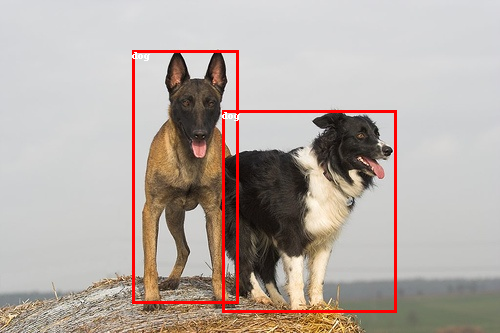

In [4]:
from PIL import Image, ImageDraw
idx = np.random.randint(len(antns))
filename, boxes, labels = parse_xml(os.path.join('VOC2007/train/Annotations', antns[idx]))
image = Image.open(os.path.join('VOC2007/train/JPEGImages',filename))
draw = ImageDraw.Draw(image)
for i, ibox in enumerate(boxes):
    draw.rectangle([(ibox[0], ibox[1]), (ibox[2], ibox[3])], outline='red', width=3)
    draw.text((ibox[0], ibox[1]), text = class_num2str[labels[i]])
image

Clone the PyTorch vision repo and copy some python files containing implementation on evaluation, transformations, loss function etc.

In [5]:
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./
from engine import train_one_epoch, evaluate
import utils
import transforms as T

Cloning into 'vision'...
remote: Enumerating objects: 469758, done.
remote: Counting objects: 100% (50216/50216), done.
remote: Compressing objects: 100% (2331/2331), done.
remote: Total 469758 (delta 47952), reused 50017 (delta 47809), pack-reused 419542
Receiving objects: 100% (469758/469758), 922.15 MiB | 31.17 MiB/s, done.
Resolving deltas: 100% (437055/437055), done.


###Data Loader
An example of PyTorch data generator for object detector can be found [here](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/datasets.py) or [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html). A simplified version of the data generator can be found below.

In [6]:
class PASCALVOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.antns = sorted(os.listdir(os.path.join(root, 'Annotations')))

    def __getitem__(self, idx):
        # load annotation
        filename, boxes, labels = parse_xml(os.path.join(self.root, 'Annotations', self.antns[idx]))
        # load image
        img_path = os.path.join(self.root, 'JPEGImages', filename)
        img = Image.open(img_path).convert('RGB')
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = boxes.shape[0]
        # classes
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id = int(torch.tensor([idx]))
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        w,h = img.size
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)
        keep = (boxes[:, 3]>boxes[:, 1]) & (boxes[:, 2]>boxes[:, 0])
        boxes = boxes[keep]
        labels = labels[keep]
        area = area[keep]
        iscrowd = iscrowd[keep]

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.antns)

###Data Instance

In [7]:
dataset = PASCALVOCDataset(root='VOC2007/train')
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=500x375>,
 {'boxes': tensor([[263., 211., 324., 339.],
          [165., 264., 253., 372.],
          [  5., 244.,  67., 374.],
          [241., 194., 295., 299.],
          [277., 186., 312., 220.]]),
  'labels': tensor([9, 9, 9, 9, 9]),
  'image_id': 0,
  'area': tensor([7808., 9504., 8060., 5670., 1190.]),
  'iscrowd': tensor([0, 0, 0, 0, 0])})

###Model
In this workshop, we will be using [Faster R-CNN](https://arxiv.org/abs/1506.01497) which is a model that predicts both bounding boxes and class scores for potential objects in the image. The detection models available within PyTorch can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Check the PyTorch implementation of Faster R-CNN with ResNet-50 backbone [here](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py)

In [8]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

###Transformations
We only use random horizontal flip transformation. One can use some other transformations, such as affine etc.

In [9]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    #transforms.append(T.ToTensor())
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

###Initialization of Dataset and Data Loader

In [10]:
# use our dataset and defined transformations
train_dataset = PASCALVOCDataset(root= 'VOC2007/train', transforms = get_transform(train=True))
test_dataset = PASCALVOCDataset(root= 'VOC2007/test', transforms = get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
train_indices = torch.randperm(len(train_dataset)).tolist()
test_indices = torch.randperm(len(test_dataset)).tolist()
# first n examples
# because of the constraint of computational resources, I just use 100 samples.
# Please feel free to use more samples if you have enough resources
n = 100
train_dataset = torch.utils.data.Subset(train_dataset, train_indices[:n])
test_dataset = torch.utils.data.Subset(test_dataset, test_indices[:n])
# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(train_indices+test_indices), len(train_dataset), len(test_dataset)))

We have: 9963 examples, 100 are training and 100 testing


###Initialization of Model and Optimizer
In this training, it is recommended to use learning rate scheduler, more details on it can be found [here](https://pytorch.org/docs/stable/optim.html).

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = len(class_str2num) + 1
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 144MB/s]


###Train and Test Loop
Read more about the `train_one_epoch()` and `evaluate()` functions [here](https://github.com/pytorch/vision/tree/master/references/detection). Details on the evaluation metrics, different parameters and following verbose can be found [here](https://cocodataset.org/#detection-eval). In this training, it is recommended to use learning rate scheduler and learning rate warm-up, more details on it can be found [here](https://pytorch.org/docs/stable/optim.html).

In [12]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [ 0/50]  eta: 0:02:46  lr: 0.000002  loss: 274.3498 (274.3498)  loss_classifier: 183.5518 (183.5518)  loss_box_reg: 1.0110 (1.0110)  loss_objectness: 88.3698 (88.3698)  loss_rpn_box_reg: 1.4172 (1.4172)  time: 3.3316  data: 0.0976  max mem: 2347
Epoch: [0]  [10/50]  eta: 0:00:31  lr: 0.000023  loss: 46.1513 (79.5512)  loss_classifier: 10.1675 (44.0236)  loss_box_reg: 3.0256 (3.1251)  loss_objectness: 23.9125 (29.7653)  loss_rpn_box_reg: 1.7454 (2.6373)  time: 0.7930  data: 0.0168  max mem: 3263
Epoch: [0]  [20/50]  eta: 0:00:20  lr: 0.000043  loss: 21.4651 (50.9653)  loss_classifier: 6.2291 (25.0368)  loss_box_reg: 1.5216 (2.1353)  loss_objectness: 14.3592 (21.7083)  loss_rpn_box_reg: 1.1721 (2.0849)  time: 0.5419  data: 0.0077  max mem: 3597
Epoch: [0]  [30/50]  eta: 0:00:12  lr: 0.000063  loss: 3.1116 (35.3129)  loss_classifier: 0.4145 (17.0925)  loss_box_reg: 0.2775 (1.5455)  loss_objectness: 1.6977 (15.1395)  loss_rpn_box_reg: 0.6457 (1.5355)  time: 0.5415  data: 0.0084

###Qualitative Results

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.dpi'] = 72
model = model.cpu()
model.eval()
for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    label_boxes = np.array(test_dataset[i][1]['boxes'])
    #put the model in evaluation mode
    with torch.no_grad():
        prediction = model([img])
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])], outline ="green", width =3)
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        label = prediction[0]['labels'][element].cpu().item()
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals= 4)
        if score > 0.6:
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline ='red', width =3)
            draw.text((box[0], box[1]), text = class_num2str[label] + ', ' + str(score))
    plt.imshow(image)
    plt.show()